# Expected error probabilities of maximum a posteriori strategies based on Clarke's trine experiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, binom

In [2]:
# box and measurement parameters
N = 10 # half number of photons per box
n = np.arange(2*N)

In [6]:
def CombsProbs( n , m , p , q , mask ):
    r = np.zeros_like(n[0], dtype="float64")
    r += binom( m[1] + m[2] , m[1] , where = mask )*np.power(p[1], m[1] , where = mask )*np.power(p[2], m[2] , where = mask )
    r *= binom( N - m[0] , m[1] + m[2], where = mask )*np.power(p[3], N - m[0] - m[1] - m[2], where = mask )
    
    r *= binom( n[1] + n[2] - m[1] - m[2], n[1] - m[1], where = mask )*np.power(q[1], n[1] - m[1], where = mask )*np.power(q[2], n[2] - m[2], where = mask )
    r *= binom( N + m[0] - n[0], n[1] + n[2] - m[1] - m[2], where = mask )*np.power(q[3], N + m[0] + m[1] + m[2] - n[0] - n[1] - n[2], where = mask )
    return r

def likelihood( n0, n1, n2 , theta = 0, N = 1 , box = "A"):

    
    P = np.zeros((len(n0), len(n1), len(n2)), dtype="float64")
    
    c = np.cos(2*theta)
    s = np.sin(2*theta)
    
    if box == "C":
        
        N0, N1, N2 = np.meshgrid(n0, n1, n2, indexing="ij")
        
        p = [1/3, c**2/6, (1+s**2/3)/4, (1+s**2/3)/4]
        
        C = np.power(p[0], N0)*binom(N0 + N1 , N0) *np.power( p[1] , N1)*np.power( p[2] , 2*N - N0 - N1)
        P += C*binom( N0 + N1 + N2, N2)*binom( 2*N , N0 + N1 + N2)
                        
    elif box == "A":
        
        N0, N1, N2, H2 = np.meshgrid(n0, n1, n2, np.arange(N+1), indexing="ij")
        H2min = np.maximum(0 , N2 - N)
        H2max = np.minimum(N2, N - N0 - N1 )
        
        Nmask = (N0 + N1 + N2 <= 2*N)
        Hmask = H2 <= N
        H2mask = (H2 >= H2min)*(H2 <= H2max)
        mask = Nmask*Hmask*H2mask
        
        p = np.array([2/3, c**2/3, s**2/6, s**2/6], dtype="float64")
        q = np.array([0, 0, 1/2 , 1/2], dtype="float64")
        
        C = binom(N , N0, where = mask )*np.power(p[0], N0, where = mask )
        
        Q = np.zeros_like(N0, dtype="float64")
        
        n = [N0, N1, N2]
        m = [N0, N1, H2]
        
        Q = C*CombsProbs( n , m , p , q, mask)
        P += Q.sum(axis=3)
    
    elif box == "B":

        N0, N1, N2, L0, L1, L2 = np.meshgrid(n0, n1, n2, np.arange(N+1), np.arange(N+1), np.arange(N+1), indexing="ij")
        
        L0min = np.maximum(0 , N0 - N)
        L1min = np.maximum(0 , N1 - N)
        L2min = np.maximum(0 , N2 - N)
        L0max = np.minimum(N0, N)
        L1max = np.minimum(N1, N - L0)
        L2max = np.minimum(N2, N - L0 - L1)
        
        Nmask = (N0 + N1 + N2 <= 2*N)
        Lmask = (L0 + L1 + L2 <= N)
        L0mask = (L0 >= L0min)*(L0 <= L0max)
        L1mask = (L1 >= L1min)*(L1 <= L1max)
        L2mask = (L2 >= L2min)*(L2 <= L2max)
        mask = Nmask*Lmask*L0mask*L1mask*L2mask
        
        p = [1/3, c**2/6, (s+np.sqrt(3))**2/12, (s-np.sqrt(3))**2/12]
        q = [1/3, c**2/6, (s-np.sqrt(3))**2/12, (s+np.sqrt(3))**2/12]
        
        C = binom(N , L0, where = mask )*binom(N , N0-L0, where = mask )*np.power(p[0], N0 )
        
        Q = np.zeros_like(N0, dtype="float64")
        
        n = [N0, N1, N2]
        m = [L0, L1, L2]
        
        Q = C*CombsProbs( n , m , p , q, mask)
        P += Q.sum(axis=(3,4,5))

    return P


def EEP( LHA, LHB, LHC ): # expected error probability
    
    # inferring events when the maximum likelihood is well defined
    Ainfer_event = (LHA>LHB)*(LHA>LHC)
    Binfer_event = (LHB>LHA)*(LHB>LHC)
    Cinfer_event = (LHC>LHA)*(LHC>LHB)
    
    ABcoincidence = (LHA==LHB)*(LHA!=LHC)
    ACcoincidence = (LHA==LHC)*(LHA!=LHB)
    BCcoincidence = (LHB==LHC)*(LHA!=LHB)
    
    ABCcoincidence = (LHA==LHB)*(LHA==LHC)
    
    # EXPECTED CONDITIONAL SUCCESS PROBABILITIES
    ESPA = LHA[Ainfer_event].sum() # when the maximum likelihood is evidently A, infer A correctly
    ESPA += LHA[ABcoincidence].sum()/2+LHA[ACcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPA += LHA[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    ESPB = LHB[Binfer_event].sum() # when the maximum likelihood is evidently B, infer B correctly
    ESPB += LHB[ABcoincidence].sum()/2+LHB[BCcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPB += LHB[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    ESPC = LHC[Cinfer_event].sum() # when the maximum likelihood is evidently C, infer C correctly
    ESPC += LHC[ACcoincidence].sum()/2+LHC[BCcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPC += LHC[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    EEP_dict = {
        "A": 1 - ESPA,
        "B": 1 - ESPB,
        "C": 1 - ESPC,
        "Overall": 1 - (ESPA+ESPB+ESPC)/3.
    }
    
    return EEP_dict

In [7]:
theta = np.arcsin(1/np.sqrt(3))/2
LHA = likelihood( n , n , n , theta , N , "A")
LHB = likelihood( n , n , n , theta , N , "B")
LHC = likelihood( n , n , n , theta , N , "C")

np.save("TrineLikelihood_BoxA_theta{:.3f}_N{:d}".format(theta, 2*N), LHA)
np.save("TrineLikelihood_BoxB_theta{:.3f}_N{:d}".format(theta, 2*N), LHB)
np.save("TrineLikelihood_BoxC_theta{:.3f}_N{:d}".format(theta, 2*N), LHC)

In [8]:
print(LHA.sum())
print(LHB.sum())
print(LHC.sum())

0.9999999999999992
0.9999999997131156
0.999999999705722


In [9]:
LHA[np.isnan(LHA)]

array([], dtype=float64)

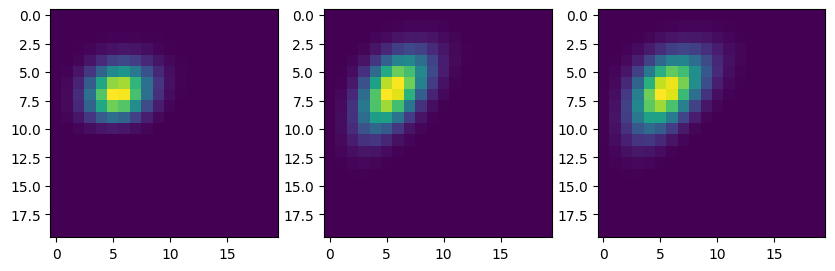

In [10]:
fig, ax = plt.subplots( 1 , 3 , figsize=(10,4) )
ax[0].imshow(LHA.sum(axis=1))
ax[1].imshow(LHB.sum(axis=1))
ax[2].imshow(LHC.sum(axis=1))
plt.show()

In [11]:
EEP(LHA , LHB, LHC )

{'A': 0.09059653269912682,
 'B': 0.6565789428557716,
 'C': 0.8135395090019923,
 'Overall': 0.5202383281856302}

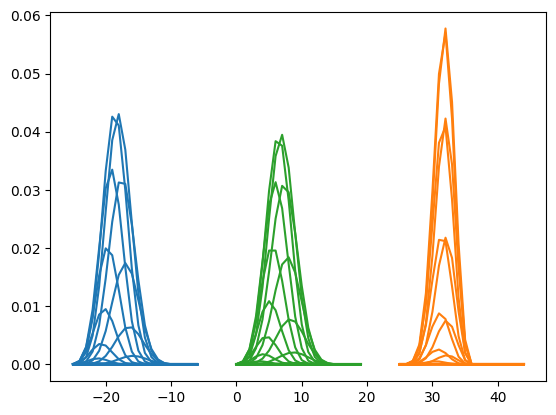

In [12]:
#plt.plot(np.arange(2*N), LHA, color="C0")
#plt.plot(np.arange(2*N), LHB, color="C1")
plt.plot(n, LHC.sum(axis=1), color="C2")
plt.plot(25+n, LHA.sum(axis=1), color="C1")
plt.plot(-25+n, LHB.sum(axis=1), color="C0")
plt.show()

# For varying values of N

In [31]:
theta = np.pi/2
N = np.arange(50+1)

EEPs = np.zeros((len(N),4), dtype="object")

for j in range(len(N)):
    print(N[j])
    LHA = np.round(likelihood( np.arange(2*N[j]) , np.arange(2*N[j]), theta , N[j], "A"), 12)
    LHB = np.round(likelihood( np.arange(2*N[j]) , np.arange(2*N[j]), theta , N[j], "B"), 12)
    LHC = np.round(likelihood( np.arange(2*N[j]) , np.arange(2*N[j]), theta , N[j], "C"), 12)
    
    EEPs = np.array(list(EEP(LHA,LHB,LHC).values()))
    np.save("3BPClarkeMAPEEP_theta{:.3f}_N{:d}.npy".format(theta, 2*N[j]), EEPs)
    
#np.save("3BPClarkeMAPEEP_Nmax{:d}.npy".format(2*Nmax), EEPs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


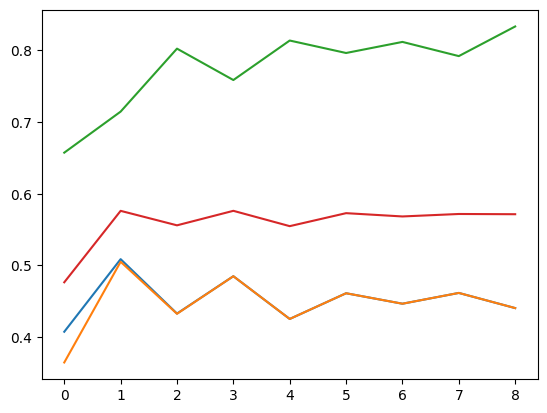

In [47]:
plt.plot(EEPs[1:,0])
plt.plot(EEPs[1:,1])
plt.plot(EEPs[1:,2])
plt.plot(EEPs[1:,3])

# For varying values of $\theta$

In [13]:
theta = np.linspace(0, np.pi, 51)
N = 50
n = np.arange(2*N)

for j in range(len(theta)):
    print(theta[j])
    LHA = np.round(likelihood( n , n , n, theta[j] , N, "A"), 12)
    LHB = np.round(likelihood( n , n , n, theta[j] , N, "B"), 12)
    LHC = np.round(likelihood( n , n , n, theta[j] , N, "C"), 12)
    
    EEPs = np.array(list(EEP(LHA,LHB,LHC).values()))
    np.save("3BPTrineMAPEEP_opt_theta{:.3f}_N{:d}.npy".format(theta[j], 2*N), EEPs)

0.0


MemoryError: Unable to allocate 494. GiB for an array with shape (100, 100, 100, 51, 51, 51) and data type int32

In [95]:
EEPs = np.zeros((len(theta),4), dtype="object")

for j in range(len(theta)):
    
    EEPs[j] = np.load("3BPTrineMAPEEP_theta{:.3f}_N{:d}.npy".format(theta[j], 2*N))

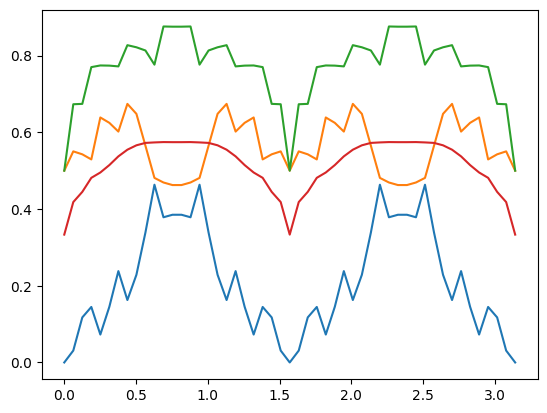

In [98]:
plt.plot(theta, EEPs[:,0])
plt.plot(theta, EEPs[:,1])
plt.plot(theta, EEPs[:,2])
plt.plot(theta, EEPs[:,3])
plt.show()